In [1]:
%ls data/dogscats_new
%matplotlib inline

sample_submission.csv  test/     train/     valid/
submission_res2.csv    test.zip  train.zip


In [2]:
data_path = "data/dogscats_new/"

In [3]:
import numpy as np
import math
import cv2
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD, RMSprop, Adam
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential, Model

from keras.layers import Dense

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)



# Get data for training and validation
Import and init ImageData generator for future image processing from directory

In [4]:

train_imgs = ImageDataGenerator()
valid_imgs = ImageDataGenerator()
test_imgs = ImageDataGenerator()

# Load VGG19 keras model

In [5]:
vgg19 = VGG16()

### Remove last layer from vgg19
Since this model is based on imagenet but we want to have only 2 categories instead for 1000 like imagenet have

In [6]:

vgg19.layers.pop()
for layer in vgg19.layers: 
    layer.trainable=False

last = vgg19.layers[-1].output
x = Dense(2, activation="softmax")(last)
model = Model(vgg19.input, x)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [7]:
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'] )

In [8]:
img_size = 224 # because vgg19 input is 224,244,3 ; 3 here is for RGB 
batch_size = 64
img_batch_size = 8
train_imgs_gen = train_imgs.flow_from_directory(data_path + "train", 
                                                target_size=(img_size,img_size), 
                                                batch_size=img_batch_size,
                                                color_mode = "rgb",
                                                class_mode='categorical',
                                                shuffle=True)

valid_imgs_gen = valid_imgs.flow_from_directory(data_path + "valid", 
                                                target_size=(img_size,img_size), 
                                                batch_size=img_batch_size,
                                                color_mode = "rgb",
                                                class_mode='categorical',
                                                shuffle=True)

test_imgs_gen = test_imgs.flow_from_directory(data_path + "test",
                                              target_size=(img_size,img_size), 
                                              batch_size=img_batch_size,
                                              color_mode = "rgb",
                                              class_mode=None,
                                              shuffle=False)
model.load_weights('my_custom_vgg16_model_sgd_4.weight')

Found 22778 images belonging to 2 classes.
Found 2222 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [ ]:
# model.fit_generator(  train_imgs_gen, 
#                       samples_per_epoch= train_imgs_gen.nb_sample,
#                       nb_epoch = 1,
#                       validation_data = valid_imgs_gen,
#                       nb_val_samples = valid_imgs_gen.nb_sample
#                      )
# model.save_weights('my_custom_resnet50_model_adam.weight')

In [ ]:
# model.fit_generator(  train_imgs_gen, 
#                       samples_per_epoch= train_imgs_gen.nb_sample,
#                       nb_epoch = 1,
#                       validation_data = valid_imgs_gen,
#                       nb_val_samples = valid_imgs_gen.nb_sample
#                      )
# model.save_weights('my_custom_resnet50_model_adam_2.weight')

In [ ]:
# model.fit_generator(  train_imgs_gen, 
#                       samples_per_epoch= train_imgs_gen.nb_sample,
#                       nb_epoch = 1,
#                       validation_data = valid_imgs_gen,
#                       nb_val_samples = valid_imgs_gen.nb_sample
#                      )
# model.save_weights('my_custom_vgg19_model_adam_3.weight')

In [ ]:
model.fit_generator(  train_imgs_gen, 
                      samples_per_epoch= train_imgs_gen.nb_sample,
                      nb_epoch = 1,
                      validation_data = valid_imgs_gen,
                      nb_val_samples = valid_imgs_gen.nb_sample
                     )
model.save_weights('my_custom_vgg19_model_adam_5.weight')

Epoch 1/1
22770/22778 [============================>.] - ETA: 0s - loss: 0.0568 - acc: 0.9780  

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


array([[ 0.,  1.]], dtype=float32)

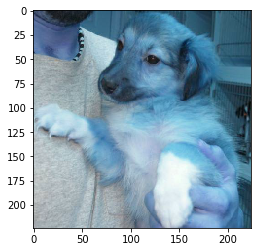

In [10]:
from PIL import Image

img = cv2.imread('./data/dogscats_new/test/unknown/333.jpg')
img=cv2.resize(img,(224,224))
img=np.array(img).reshape((224,224,3))
plt.imshow(img)
img = img.reshape((1,) + img.shape)
np.rint(model.predict(img))


In [ ]:
model_gen = model.predict_generator(test_imgs_gen, test_imgs_gen.nb_sample)

In [ ]:
submission_file_name = 'submission_vgg19_3epoch.csv'
filenames = test_imgs_gen.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])
isdog = model_gen[:,1]
isdog = isdog.clip(min=0.05, max=0.95)
subm = np.stack([ids,isdog], axis=1)
subm[:5]
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

In [ ]:
from IPython.display import FileLink
FileLink(submission_file_name)